In [1]:
from pylab import *
import pandas as pd
from timeit import default_timer as timer
import sys
#sys.path.insert(0,'/Users/zihengchen/Documents/ImageAlgorithm3D/code/')
from HGCalImageAlgo3D_opencl_kernel import *

lsz,context,prg = openclkernel(DeviceID=0)
queue = cl.CommandQueue(context)
# For deviceid:
# 0 ...... Intel-Core-i7 CPU: 0001 WI/WG
# 1 ...... Intel-IrisPro GPU: 0512 WI/WG
# 2 ...... NVidia-GT750M GPU: 1024 WI/WG

demoevent = "id==1"
DatasetDir  = '/Users/zihengchen/Documents/HGCal/workplace/data/'
DatasetFile = 'CMSSW93X_pt35_pu200'
df = pd.read_hdf(DatasetDir+"input/"+DatasetFile+"_rechit.h5",key="table")
dfgen = pd.read_pickle(DatasetDir+"input/"+DatasetFile+"_gen.pkl")

In [2]:
AFFINITY_Z = 1.2,
KERNAL_R = 4.0,#cm
KERNAL_Z = 2.4,#cm
KERNAL_EXPC = 0.5, #cm
MAXDISTANCE = 200,#cm
DECISION_RHO_KAPPA = 10,
DECISION_NHD = 4.0,#cm
CONTINUITY_NHD = 6.0#cm

# 0.Load Events

In [3]:
dfevt = df.query(demoevent)
dfevt = dfevt.reset_index(drop=True)
x,y,z,e = np.array(dfevt.x),np.array(dfevt.y),AFFINITY_Z*np.array(dfevt.z),np.array(dfevt.energy)

# 1. Find rho and NearestHigher

In [4]:
nrech = np.int32(e.size)
LOCALSIZE = int(lsz)
GLOBALSIZE= (int(nrech/LOCALSIZE)+1)*LOCALSIZE

x = x.astype(np.float32)
y = y.astype(np.float32)
z = z.astype(np.float32)
e = e.astype(np.float32)
rho     = np.zeros_like(e)
rhorank = np.zeros_like(e).astype(np.int32)
nh      = np.zeros_like(e).astype(np.int32)
nhd     = np.zeros_like(e)

start = timer()
mem_flags = cl.mem_flags
d_x = cl.Buffer(context, mem_flags.READ_ONLY | mem_flags.COPY_HOST_PTR, hostbuf=x)
d_y = cl.Buffer(context, mem_flags.READ_ONLY | mem_flags.COPY_HOST_PTR, hostbuf=y)
d_z = cl.Buffer(context, mem_flags.READ_ONLY | mem_flags.COPY_HOST_PTR, hostbuf=z)
d_e = cl.Buffer(context, mem_flags.READ_ONLY | mem_flags.COPY_HOST_PTR, hostbuf=e)
d_rho     = cl.Buffer(context, mem_flags.READ_WRITE, rho.nbytes)
d_rhorank = cl.Buffer(context, mem_flags.READ_WRITE, rhorank.nbytes)
d_nh      = cl.Buffer(context, mem_flags.READ_WRITE, nh.nbytes)
d_nhd     = cl.Buffer(context, mem_flags.READ_WRITE, nhd.nbytes)

prg.rho_opencl(queue, (GLOBALSIZE,), (LOCALSIZE,),
               d_rho, 
               nrech,np.float32(KERNAL_R), np.float32(KERNAL_Z), np.float32(KERNAL_EXPC),
               d_x,d_y,d_z,d_e
              )

prg.rhoranknh_opencl(queue, (GLOBALSIZE,), (LOCALSIZE,),
              d_rhorank,d_nh,d_nhd,
              nrech,d_x,d_y,d_z,d_rho
             )

#prg.rhorank_opencl(queue, (GLOBALSIZE,), (LOCALSIZE,),
#                   d_rhorank,
#                   nrech,d_rho
#                   )
#prg.nh_opencl(queue, (GLOBALSIZE,), (LOCALSIZE,),
#              d_nh,d_nhd,
#              nrech,d_x,d_y,d_z,d_rho
#             )

cl.enqueue_copy(queue, rho, d_rho)
cl.enqueue_copy(queue, rhorank, d_rhorank)
cl.enqueue_copy(queue, nh, d_nh)
cl.enqueue_copy(queue, nhd, d_nhd)

end = timer()
print("number of rechits: {}".format(nrech))
print("time: {:3.6} ms".format(1000*(end - start)))

number of rechits: 148530
time: 40102.7 ms


# 2. Asign Clusters

In [5]:
cluster = -1*np.ones(nrech,int)
DECISION_RHO = rho.max()/DECISION_RHO_KAPPA

# 2.1 convert rhorank to argsortrho 0(N)
argsortrho = np.zeros(nrech,int)
argsortrho[rhorank] = np.arange(nrech)

# 2.2 find seeds
selectseed = (rho>DECISION_RHO) & (nhd>DECISION_NHD)
seedrho = rho[selectseed]
temp = seedrho.argsort()[::-1]
seedid = np.empty(len(seedrho), int)
seedid[temp] = np.arange(len(seedrho))
cluster[selectseed] = seedid
dfevt['isseed'] = pd.Series(selectseed.astype(int), index=dfevt.index)

# 2.3 asign clusters to seeds
for ith in range(nrech):
    i = argsortrho[ith]
    if  (cluster[i]<0) & (nhd[i]<CONTINUITY_NHD):
        cluster[i] = cluster[nh[i]]

In [6]:
dfevt['rho'] = pd.Series(rho, index=dfevt.index)
dfevt['rhorank'] = pd.Series(rhorank, index=dfevt.index)
dfevt['nh'] = pd.Series(nh, index=dfevt.index)
dfevt['nhd'] = pd.Series(nhd, index=dfevt.index)
dfevt['cluster'] = pd.Series(cluster, index=dfevt.index)
#dfevt.to_pickle("../data/test_"+DatasetFile+".pkl")
#dfevt.to_csv("../data/test_"+DatasetFile+".csv")

# Done! make validation plots

### Decision Plot

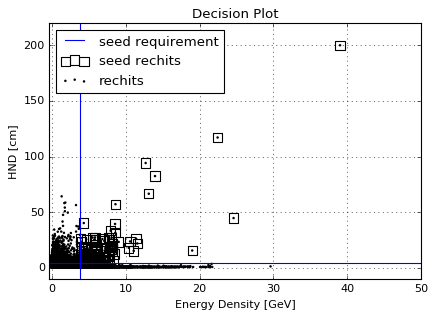

In [7]:
%matplotlib inline
plt.style.use('classic')
plt.rc("figure",facecolor="w",figsize=(6,4))
plt.rc("font",size=10)
plt.rc("savefig",dpi=300)

plt.scatter(dfevt.rho[selectseed],dfevt.nhd[selectseed],marker='s',
            s=70,edgecolor="k",color="None",label="seed rechits")
plt.scatter(dfevt.rho,dfevt.nhd,marker='.',edgecolor="None",color="k",label="rechits")
plt.axvline(DECISION_RHO,color="b",label="seed requirement")
plt.axhline(DECISION_NHD,color="b")

plt.xlabel("Energy Density [GeV]")
plt.ylabel("HND [cm]")
plt.legend(loc="upper left",fontsize=12)
plt.xlim(-0.3)
plt.ylim(-10,220)
plt.grid(True)
plt.title("Decision Plot",fontsize=12)

plt.savefig("../../plot/decision_opencl.png")

### Plotly EventDisplay

In [8]:
gen = dfgen.query(demoevent)

In [11]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
init_notebook_mode(connected=True)

dfevt = dfevt.reset_index(drop=True)

tempdf = dfevt.query('cluster>-1')
tempx,tempy,tempz,tempe,tempclst = tempdf.ox,tempdf.oy,tempdf.oz,tempdf.energy,tempdf.cluster.max()-tempdf.cluster
rechits = go.Scatter3d(x=tempx,y=tempz,z=tempy,
                       mode='markers',
                       marker=dict(size=7*tempe**0.5,color=tempclst,colorscale='Jet',cmax=tempclst.max(),cmin=0,opacity=0.5,
                                   line = dict(width = 0))) 
#tempdf = dfevt.query('(cluster==-1)')
tempdf = dfevt.query('(cluster==-1) & (energy>0.02)')

tempx,tempy,tempz,tempe,tempclst = tempdf.ox,tempdf.oy,tempdf.oz,tempdf.energy,-1
noise   = go.Scatter3d(x=tempx,y=tempz,z=tempy,
                       mode='markers',
                       marker=dict(size=0.8,color="black",opacity=0.3,
                                   line = dict(width = 0))) 

genpart = go.Scatter3d(x=np.array([0,gen.gx]),
                       y=np.array([0,gen.gz]),
                       z=np.array([0,gen.gy]),
                       mode='lines',marker=dict(size=0,color="red",opacity=1)) 

data = [rechits,noise,genpart]
layout = go.Layout(scene=dict(xaxis=dict(title='x (cm)'), yaxis=dict(title='z (cm)'), zaxis=dict(title='y (cm)')),
                   margin=dict(l=0,r=0,b=0,t=0))

fig = go.Figure(data=data, layout=layout)
py.plot(fig, filename='SinglePi_PU200')

/Users/zihengchen/anaconda/lib/python3.6/site-packages/plotly/plotly/plotly.py:218: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.



The draw time for this plot will be slow for all clients.


/Users/zihengchen/anaconda/lib/python3.6/site-packages/plotly/api/v1/clientresp.py:40: UserWarning:

Estimated Draw Time Too Long



'https://plot.ly/~zihengchen/18'